# Obesity regression model testing for the affect of food access related variables

In [1]:
# loading in necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
import statsmodels.api as sma
import sklearn
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, GridSearchCV, ShuffleSplit
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

## Dataframe setup

Although our data was cleaned for the EDA section, some extra cleaning is required for running our model. Examples include, creating dummy variables as well as dropping columns with too many missing values as well as counties with missing values in any column. Below, we load in the required packages as well as clean as described above. 

In [2]:
# loading in obesity data from our EDA and dropping columns that have too many null values. Additonally, hawaii and alaska
# had no inputs for obesity rates which are necessary for our model. Thus, they were dropped. 
# furthermore, obesity proxies that went into creating healthy score access was also dropped.
obesity_df = pd.read_csv("../../processed_data/obesity_eda.csv")
obesity_df[~obesity_df.region.str.contains('O')]
obesity_df = obesity_df.drop(columns = ['primary_minority', 'supercenter_access_score', 'grocery_access_score', 'fullservice_access_score', 'farmersmarket_access_score', 'wic_available_per1000', 'snap_bens_per1000'])
obesity_df['percent_other'] = obesity_df['percent_nhpi'] + obesity_df['percent_multi']

# Loading in car access data
car_access_df = pd.read_csv("../../processed_data/car_access_2017.csv")
unemployment_df = pd.read_csv("../../processed_data/unemployment _2017.csv")
unemployment_df = unemployment_df[["fips","total_unemployment_rate_over_16", "total_educated_some_college_or_associates_25_64", "pop_est_over_16"]]
unemployment_df["some_college_rate"] = unemployment_df["total_educated_some_college_or_associates_25_64"]/unemployment_df["pop_est_over_16"]
unemployment_df = unemployment_df[["fips","total_unemployment_rate_over_16", "some_college_rate"]]

# Merged the two data sets
obesity_df = pd.merge(obesity_df, car_access_df, how = 'left', on = 'fips')
obesity_df = pd.merge(obesity_df, unemployment_df, how = 'left', on = 'fips')
obesity_df = obesity_df.drop(columns = ['percent_asian_low_access_15','percent_pop_low_access_15', 'percent_low_income_low_access_15',
       'percent_snap_low_access_15', 'percent_child_low_access_15',
       'percent_white_low_access_15', 'percent_nhna_low_access_15','nhpi_low_access_15', 'percent_no_car_low_access_15', 'percent_senior_low_access_15',
       'percent_black_low_access_15', 'percent_hispanic_low_access_15',
       'percent_nhpi_low_access_15', 'percent_multiracial_low_access_15'])


# made some numerical variables easier to read 
obesity_df['percent_no_car'] = obesity_df['percent_no_car'] * 100
obesity_df['pop_estimate'] = obesity_df['pop_estimate']/1000

We wanted to find the counties within the contingous US that could be described as food desserts. One definition of 'food dessert', provided by the Annie E Casie foundation can be found [here](https://www.aecf.org/blog/exploring-americas-food-deserts),and other sources present a similar idea. The food insecurity variable in our data, obtained from Feeding America and coded as the fi_rate column, was calculated using many of the factors already described in the food insecurity definition found above; the calculation can be found [here](https://www.feedingamerica.org/sites/default/files/research/map-the-meal-gap/2016/2016-map-the-meal-gap-technical-brief.pdf). What was missing was a variable for access to food. Considering we had already created a proxy for access to food (healthy_access_category which encompasses grocery stores, supercenters, restaurants, and farmers markets), we decided to use both fi_rate and healthy_access_category to determine whether or not a county was labelled as being a food dessert.

The third quartile for food insecurity is at about 15.200000 meaning 75 percent is at or below that value. We decided that any county in the highest 25% would be considered the 'highest tier' of food insecurity. We chose to take the top 25% because it is marginally conservative. We then decided too be food insecure, the county not only had to be within the top 25% of insecure counties in the United states but also have either low or medium access to healthy foods.

In [3]:
# Making our food dessert categorical variable. 
conditions = [(obesity_df["fi_rate"] > 15) & (obesity_df["healthy_access_category"] != 'high'), 
              (obesity_df["fi_rate"] <= 15)]
values = [1, 0]

obesity_df["food_dessert"] = np.select(conditions, values)

# dropping any remaining null values so our model can work
obesity_df = obesity_df.dropna()

# creating dummy variables; the VIF test does not take in categorical variables
obesity_df['region'] = obesity_df['region'].map({'N':1, 'M':2, 'S':3, 'W':4})
obesity_df['healthy_access_category'] = obesity_df['healthy_access_category'].map({'low':1, 'medium':2, 'high':3})
obesity_df['class_category'] = obesity_df['class_category'].map({'low_income':1, 'lower_mid_class':2, 'mid_class':3, 'highest_income': 4})

## Looking for multicolinearity in potential predictors of interest

For the linear regression model, we want to include variables that have been linked to obesity in some capacity within the literature that we have access to. However, a linear regression model assumes that all predictors are independent of eachother. Thus, we performed a Variance Inflation Factor (VIF) test to ensure that the variables that went into the model did not have high colinearity. Originally, all variables that met the criteria of being linked to obesity, were tested for VIF. Then some were removed to view if that lowered the colinearity of other variables. In the end we were left with 11 variables with a VIF below 10: grocery store concentration, supercenter concentration, convenience store concentration, speciality store concentration, fast food restaurant concentration, full service restaurant , percent of people with out a car, unemployment rate, population, percent of farmers markets that accept credit cards,percent of farmers markets that accept, and percent of farmers markets selling fruits and vegetables.

In [4]:
pot_vars = obesity_df[['grocery_per1000', 'super_per1000',
       'convenience_per1000', 'specialty_per1000', 
       'fast_food_per1000', 'full_service_per1000', 'school_lunch_prog_17',
       'percent_no_car', 'total_unemployment_rate_over_16','pct_fm_accept_wic', 'pct_fm_credit', 
       'pct_fm_sell_frveg']]

In [5]:
#https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/
# creating a blank dataframe followed by adding each column to a new column called feature
vif_data = pd.DataFrame()
vif_data["feature"] = pot_vars.columns

# for every feature in vif_data, run VIF on it 
vif_data["VIF"] = [variance_inflation_factor(pot_vars.values, i)
                          for i in range(len(pot_vars.columns))]

# filter the data to include VIF less than ten
sig_vif_data = vif_data[vif_data["VIF"] < 10]

In [6]:
sig_vif_data

,feature,VIF
0,grocery_per1000,3.606439
1,super_per1000,1.954283
2,convenience_per1000,6.284144
3,specialty_per1000,1.752720
4,fast_food_per1000,6.537065
5,full_service_per1000,4.880885
7,percent_no_car,5.201971
8,total_unemployment_rate_over_16,6.740751
9,pct_fm_accept_wic,1.632950
10,pct_fm_credit,4.149732


## Running and testing multiple regression model

First, we created the model using statsmodels in order to get a deeper understanding of the statistics behind our model. All the variables from above (VIF < 10) were initially put into the model, and those with high p-values (p-value > 0.05) were removed.

- The variables that made into our model were supercenter concentration, convenience store concentration, speciality store concentration, fast food restaurant concentration, full service restaurant concentration ,percent of farmers markets that accept credit cards,percent of farmers markets that accept wic, percent of farmers markets selling fruits and vegetables,population, and unemployment rate.
    - Together, these variables produced an r-squared value 0.334 (meaning about 33% of the variance within obesity can be explained by those specific variables).
    - When tested using kfold validation (3 folds), the model had a prediction accuracy of 28.33%. Thus, this model is not very accurate and not currently appropriate for use in advising counties on what changes they should make to lower obesity. What it does support, is that access to food (especially supercenters) does significantly affect obesity.

In [7]:
# code was modeled and influenced by DS4A (Correlation One) material
formula= 'obesity_rate ~ super_per1000 + convenience_per1000 + specialty_per1000 + pct_fm_accepting_snap + pct_fm_credit + fast_food_per1000 + full_service_per1000 + pop_estimate + percent_no_car + total_unemployment_rate_over_16'
model1 = sm.ols(formula = formula, data = obesity_df)
lin_reg = model1.fit()
print(lin_reg.summary())

                            OLS Regression Results                            
Dep. Variable:           obesity_rate   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     153.6
Date:                Wed, 04 Aug 2021   Prob (F-statistic):          1.10e-261
Time:                        04:25:46   Log-Likelihood:                -8358.4
No. Observations:                3081   AIC:                         1.674e+04
Df Residuals:                    3070   BIC:                         1.681e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [8]:
obesity_ml_df = obesity_df[['super_per1000', 'convenience_per1000', 
       'specialty_per1000', 'fast_food_per1000', 'full_service_per1000', 'obesity_rate',
       'percent_no_car', 'total_unemployment_rate_over_16', 'pop_estimate', 'pct_fm_accepting_snap', 'pct_fm_credit']]

In [9]:
# creating our x and y values
x = obesity_ml_df.drop('obesity_rate', axis=1).values
y = obesity_ml_df['obesity_rate'].values

# making a training and test set
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.20, random_state=100)
model = LinearRegression()
model.fit(x_train, y_train)

# getting the accuracy of test  
result = model.score(x_test, y_test)
print("Accuracy: %.2f%%" % (result*100.0))

Accuracy: 33.25%


In [10]:
# creating a table and using describe() to see how off it is
y_pred = model.predict(x_test)
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df['off'] = df['Actual'] - df['Predicted']
df['off_absolute'] = df['off'].abs()
df.describe()

,Actual,Predicted,off,off_absolute
count,617.000000,617.000000,617.000000,617.000000
mean,31.178120,31.039036,0.139084,2.858490
std,4.471598,2.485364,3.650584,2.271983
min,16.800000,16.995080,-13.956027,0.005213
25%,28.600000,29.747341,-1.921537,1.073607
50%,31.200000,31.111359,0.236691,2.395753
75%,33.900000,32.442849,2.607721,4.085816
max,45.900000,39.900209,9.134272,13.956027


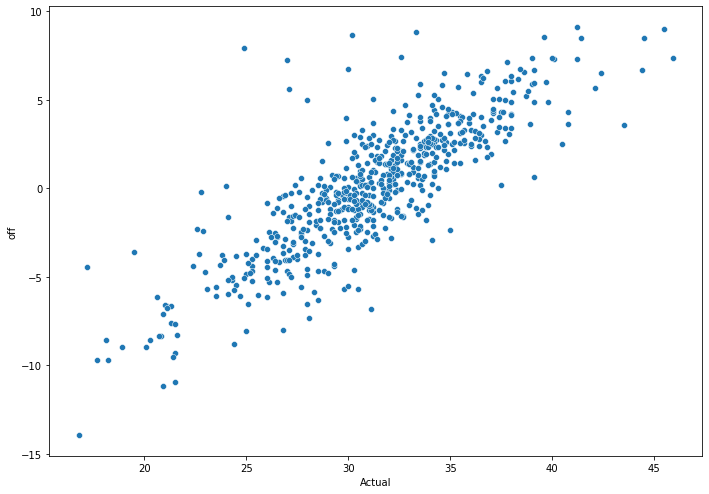

In [11]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.scatterplot(data = df, x = "Actual", y = "off")
# when less than 30 its overpredicting, when greater than 30 its underpredicting

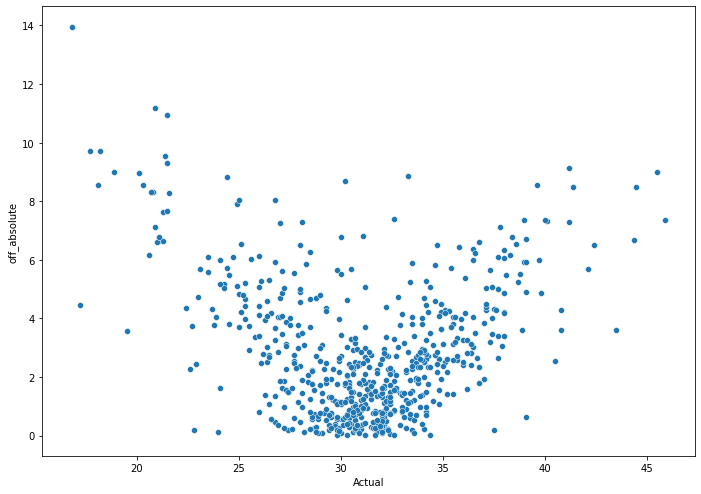

In [12]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.scatterplot(data = df, x = "Actual", y = "off_absolute")
# most accurate around 30% obesity. 

In [13]:
# using kfold validation to test our model
kfold = model_selection.KFold(n_splits= 3)
model_kfold = LinearRegression()
results_kfold = model_selection.cross_val_score(model_kfold, x, y, cv=kfold)
print("Accuracy: %.2f%%" % (results_kfold.mean()*100.0)) 

Accuracy: 28.38%


In [14]:
x_test

array([[2.21956000e-02, 9.76605851e-01, 8.87823500e-02, ...,
        4.54470000e+01, 1.00000000e+02, 1.00000000e+02],
       [0.00000000e+00, 4.73709143e-01, 0.00000000e+00, ...,
        2.10800000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.69762000e-02, 4.75333582e-01, 1.01857196e-01, ...,
        5.79450000e+01, 2.00000000e+01, 1.00000000e+02],
       ...,
       [0.00000000e+00, 8.04667069e-01, 2.01166767e-01, ...,
        1.01040000e+01, 0.00000000e+00, 0.00000000e+00],
       [1.76863000e-02, 4.59843300e-01, 7.07451230e-02, ...,
        5.68230000e+01, 0.00000000e+00, 7.50000000e+01],
       [0.00000000e+00, 1.34279685e+00, 0.00000000e+00, ...,
        5.28000000e+00, 0.00000000e+00, 0.00000000e+00]])

## Using Lasso model and GridSearchCV to view which features best predicted obesity rate.

While testing other linear regression models, we noticed that the inclusion cost per meal and summer food and lunch programs led to better model accuracy. However, they were very colinear with eachother and linear regression models assume independence. Thus, we looked for a model that could handle multicolinearity. We chose LASSO (Least Absolute Shrinkage and Selection Operator) which also aids in feature selection.

- Using Lasso and GridSearchCV from the Sci-Kit learn library, the model which utilised grocery store concentration, supercenter concentration, convenience store concentration, snap availability concentration, percent of farmers markets that accept credit, region, food insecurity rate, cost per meal, annual food budget shortfall, school lunch programs, fast food restaurant concentration, full service restaurant concentration, population estimate, median household income, unemployment rate, college education rate, and whether or not the county was labeled a food dessert. The alpha it chose 0.1.

In [15]:
# removing racial and location variables from possible predictors
obesity_subset = obesity_df.drop(columns = ['fips', 'state', 'county', 'obesity_category', 
       'percent_black', 'percent_native_american',
       'percent_asian', 'percent_multi', 'percent_nonwhite_hispanic', 'percent_white', 'percent_nhpi', 
       'percent_other', 'class_category', 'fm_sell_frveg'])

In [16]:
# creating x and y arrays
X = obesity_subset.drop('obesity_rate', axis=1).values
y = obesity_subset['obesity_rate'].values

In [17]:
# creating a list of possible variables/features
obesity_subset2 = obesity_subset.drop('obesity_rate', axis=1)
features = obesity_subset2.columns

In [18]:
# creating our testing and training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [19]:
# standardizing our data, setting up GridSearchCv, and fitting all folds
pipeline = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model',Lasso())
])

feature_search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 5, scoring="neg_mean_squared_error",verbose=3
                      )

feature_search.fit(X_train,y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV] model__alpha=0.1 ................................................
[CV] ................... model__alpha=0.1, score=-9.129, total=   0.0s
[CV] model__alpha=0.1 ................................................
[CV] .................. model__alpha=0.1, score=-10.960, total=   0.0s
[CV] model__alpha=0.1 ................................................
[CV] ................... model__alpha=0.1, score=-9.750, total=   0.0s
[CV] model__alpha=0.1 ................................................
[CV] ................... model__alpha=0.1, score=-9.971, total=   0.0s
[CV] model__alpha=0.1 ................................................
[CV] ................... model__alpha=0.1, score=-9.402, total=   0.0s
[CV] model__alpha=0.2 ................................................
[CV] ................... model__alpha=0.2, score=-9.317, total=   0.0s
[CV] model__alpha=0.2 ................................................
[CV] ..........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ... model__alpha=1.5000000000000002, score=-15.978, total=   0.0s
[CV] model__alpha=1.5000000000000002 .................................
[CV] ... model__alpha=1.5000000000000002, score=-16.755, total=   0.0s
[CV] model__alpha=1.5000000000000002 .................................
[CV] ... model__alpha=1.5000000000000002, score=-14.901, total=   0.0s
[CV] model__alpha=1.6 ................................................
[CV] .................. model__alpha=1.6, score=-17.306, total=   0.0s
[CV] model__alpha=1.6 ................................................
[CV] .................. model__alpha=1.6, score=-18.087, total=   0.0s
[CV] model__alpha=1.6 ................................................
[CV] .................. model__alpha=1.6, score=-16.691, total=   0.0s
[CV] model__alpha=1.6 ................................................
[CV] .................. model__alpha=1.6, score=-17.496, total=   0.0s
[CV] model__alpha=1.6 ................................................
[CV] .

[CV] .................. model__alpha=2.7, score=-18.972, total=   0.0s
[CV] model__alpha=2.7 ................................................
[CV] .................. model__alpha=2.7, score=-19.736, total=   0.0s
[CV] model__alpha=2.7 ................................................
[CV] .................. model__alpha=2.7, score=-18.388, total=   0.0s
[CV] model__alpha=2.7 ................................................
[CV] .................. model__alpha=2.7, score=-19.074, total=   0.0s
[CV] model__alpha=2.7 ................................................
[CV] .................. model__alpha=2.7, score=-17.135, total=   0.0s
[CV] model__alpha=2.8000000000000003 .................................
[CV] ... model__alpha=2.8000000000000003, score=-18.972, total=   0.0s
[CV] model__alpha=2.8000000000000003 .................................
[CV] ... model__alpha=2.8000000000000003, score=-19.736, total=   0.0s
[CV] model__alpha=2.8000000000000003 .................................
[CV] .

[CV] .................. model__alpha=4.5, score=-17.135, total=   0.0s
[CV] model__alpha=4.6 ................................................
[CV] .................. model__alpha=4.6, score=-18.972, total=   0.0s
[CV] model__alpha=4.6 ................................................
[CV] .................. model__alpha=4.6, score=-19.736, total=   0.0s
[CV] model__alpha=4.6 ................................................
[CV] .................. model__alpha=4.6, score=-18.388, total=   0.0s
[CV] model__alpha=4.6 ................................................
[CV] .................. model__alpha=4.6, score=-19.074, total=   0.0s
[CV] model__alpha=4.6 ................................................
[CV] .................. model__alpha=4.6, score=-17.135, total=   0.0s
[CV] model__alpha=4.7 ................................................
[CV] .................. model__alpha=4.7, score=-18.972, total=   0.0s
[CV] model__alpha=4.7 ................................................
[CV] .

[CV] .................. model__alpha=6.4, score=-19.074, total=   0.0s
[CV] model__alpha=6.4 ................................................
[CV] .................. model__alpha=6.4, score=-17.135, total=   0.0s
[CV] model__alpha=6.5 ................................................
[CV] .................. model__alpha=6.5, score=-18.972, total=   0.0s
[CV] model__alpha=6.5 ................................................
[CV] .................. model__alpha=6.5, score=-19.736, total=   0.0s
[CV] model__alpha=6.5 ................................................
[CV] .................. model__alpha=6.5, score=-18.388, total=   0.0s
[CV] model__alpha=6.5 ................................................
[CV] .................. model__alpha=6.5, score=-19.074, total=   0.0s
[CV] model__alpha=6.5 ................................................
[CV] .................. model__alpha=6.5, score=-17.135, total=   0.0s
[CV] model__alpha=6.6 ................................................
[CV] .

[CV] .................. model__alpha=8.3, score=-19.736, total=   0.0s
[CV] model__alpha=8.3 ................................................
[CV] .................. model__alpha=8.3, score=-18.388, total=   0.0s
[CV] model__alpha=8.3 ................................................
[CV] .................. model__alpha=8.3, score=-19.074, total=   0.0s
[CV] model__alpha=8.3 ................................................
[CV] .................. model__alpha=8.3, score=-17.135, total=   0.0s
[CV] model__alpha=8.4 ................................................
[CV] .................. model__alpha=8.4, score=-18.972, total=   0.0s
[CV] model__alpha=8.4 ................................................
[CV] .................. model__alpha=8.4, score=-19.736, total=   0.0s
[CV] model__alpha=8.4 ................................................
[CV] .................. model__alpha=8.4, score=-18.388, total=   0.0s
[CV] model__alpha=8.4 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done 495 out of 495 | elapsed:    1.1s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Lasso())]),
             param_grid={'model__alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])},
             scoring='neg_mean_squared_error', verbose=3)

In [20]:
# getting the best alpha
best_params = feature_search.best_params_
print(best_params)

# looking at coefficents
coefficients = feature_search.best_estimator_.named_steps['model'].coef_

# array of what was assigned importance to model and what was assigned zero
importance = np.abs(coefficients)
print(importance)

# array that shows the names of the features/variables which were not 0
np.array(features)[importance > 0]

{'model__alpha': 0.1}
[0.19702716 0.06594527 0.17941914 0.00153259 0.31844908 0.
 0.         0.         0.14567802 0.         0.5168475  0.71233116
 0.         0.70933717 0.15688915 0.86047908 0.         0.
 0.         0.25898942 0.77430701 0.27700237 0.40135329 0.
 0.         0.         0.34286625 0.10988497 0.09984923]


array(['grocery_per1000', 'super_per1000', 'convenience_per1000',
       'specialty_per1000', 'snap_available_per1000', 'pct_fm_credit',
       'region', 'fi_rate', 'cost_per_meal',
       'est_annual_food_budget_shortfall', 'school_lunch_prog_17',
       'fast_food_per1000', 'full_service_per1000', 'pop_estimate',
       'median_household_income', 'total_unemployment_rate_over_16',
       'some_college_rate', 'food_dessert'], dtype=object)

## Code for tool

In [21]:
# code was modeled and influenced by DS4A (Correlation One) material. 
formula= 'obesity_rate ~ super_per1000 + convenience_per1000 + specialty_per1000 + pct_fm_accepting_snap + pct_fm_credit + fast_food_per1000 + full_service_per1000 + pop_estimate + percent_no_car + total_unemployment_rate_over_16'
model_final = sm.ols(formula = formula, data = obesity_df)
lin_reg = model_final.fit()
print(lin_reg.summary())

                            OLS Regression Results                            
Dep. Variable:           obesity_rate   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     153.6
Date:                Wed, 04 Aug 2021   Prob (F-statistic):          1.10e-261
Time:                        04:25:47   Log-Likelihood:                -8358.4
No. Observations:                3081   AIC:                         1.674e+04
Df Residuals:                    3070   BIC:                         1.681e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [22]:
# obtain user input to put into a new dataframe that we will then use to predict obesity rates
fips = float(input())
super_input = float(input())
convenience_store = float(input())
specialty_store = float(input())
fm_snap = float(input())
fm_credit = float(input())
fast_food = float(input())
restaurant = float(input())
no_car = float(input())
unemployment = float(input())

population = obesity_df.loc[obesity_df['fips'] == fips, 'pop_estimate'].iloc[0]

1001
1
1
1
1
1
1
1
1
1


In [23]:
# we then create a new dataframe with the variables above so we can input it into the model prediction
new_vals = pd.DataFrame({'super_per1000': [super_input], 'convenience_per1000': [convenience_store],'specialty_per1000': [specialty_store], 'pct_fm_accepting_snap': [fm_snap],'pct_fm_credit': [fm_credit], 'fast_food_per1000': [fast_food], 'full_service_per1000': [restaurant], 'pop_estimate': [population],'percent_no_car': [no_car], 'total_unemployment_rate_over_16': [unemployment]})

In [24]:
new_vals

,super_per1000,convenience_per1000,specialty_per1000,pct_fm_accepting_snap,pct_fm_credit,fast_food_per1000,full_service_per1000,pop_estimate,percent_no_car,total_unemployment_rate_over_16
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,55.036,1.0,1.0


In [26]:
# the new variables are put into the new model and then the second value is the predicted obesity in the county based upon changes
xnew = sma.add_constant(new_vals)
ynewpred =  lin_reg.predict(xnew)
ynewpred

0    44.919468
dtype: float64